# Baseline implementation
This notebook implement the prediction of hypotension using the last mean artrial pressure (MAP) value. It is use as a baseline to compare with other models.

In [1]:
from pathlib import Path
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from hp_pred.experiments import bootstrap_test, load_labelized_cases, print_statistics, print_one_stat

/home/aubouinb/Nextcloud/Code/hypotension_pred/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
FEATURE_NAME = "last_map_value"
rng_seed = 42

In [3]:
# import the data frame and add the meta data to the segments
dataset_name = "30_s_dataset"

data = pd.read_parquet(f'data/datasets/{dataset_name}/cases/')
static = pd.read_parquet(f'data/datasets/{dataset_name}/meta.parquet')
data = data.merge(static, on='caseid')


data.asa = data.asa.astype(int)
data.preop_htn = data.preop_htn.astype(int)

train = data[data['split'] == "train"]
test = data[data['split'] == "test"]

In [4]:
# for each subgoup of data, create a regressor and evaluate it
n_bootstraps = 200
rng_seed = 42  # control reproducibility
rng = np.random.RandomState(rng_seed)

# create a regressor
print(f"test set contains {len(test)} sample with a prevalence of {test['label'].mean()*100:.2f}% ")
print(f"train set contains {len(train)} sample with a prevalence of {train['label'].mean()*100:.2f}%")

test = test.dropna(subset=[FEATURE_NAME])

x_test = test[FEATURE_NAME].values
y_test = test['label'].values
y_pred = 1 - x_test/120
y_label_id = test["label_id"].values


dict_results, precision_list, thr_list = bootstrap_test(y_test, y_pred, y_label_id, n_bootstraps=n_bootstraps, rng_seed=rng_seed, strategy='max_precision')

result_folder = Path("data/results")
if not result_folder.exists():
    result_folder.mkdir()
roc_results = result_folder / "baseline_results.csv"
with roc_results.open("wb") as f:
    pickle.dump(dict_results, f)



test set contains 177656 sample with a prevalence of 6.84% 
train set contains 419709 sample with a prevalence of 6.22%


100%|██████████| 200/200 [05:41<00:00,  1.71s/it]


In [14]:
print_statistics(dict_results)
print((1 - dict_results['threshold_opt'].mean())*120)
print((1 - dict_results['threshold_opt'].mean())*120 - (1 - dict_results['threshold_opt'].mean() - dict_results['threshold_opt'].std())*120)
# find mean precision at a threshold of 72mmHg
target = 0.4
target_precision = []
target_recall = []
recall = dict_results['recall']
for precision, threshold in zip(dict_results['precision'], dict_results['thr_precision']):
    id_thresh_opt_prc = int(np.argmin(np.abs(threshold - target)))
    target_precision.append(precision[id_thresh_opt_prc])
    target_recall.append(recall[id_thresh_opt_prc])
print(f"mean precision at {target} is {np.mean(target_precision):0.2f}, with a recall of {np.mean(target_recall):0.2f}")

AUC: 0.71 (0.00)
AP: 0.16 (0.00)
AUPRC: 0.21 (0.00)
Threshold: 0.45 [0.44, 0.45]
Recall: 24.0% [23.4%, 24.5%]
Precision: 28.1% (0.9%)
Specificity: 94.6% [94.4%, 94.9%]
NPV: 99.6% [99.6%, 99.6%]
F1-score: 25.9% [25.4%, 26.5%]
66.5915493607521
0.48584804901553014
mean precision at 0.4 is 0.20, with a recall of 0.68


<Figure size 1200x500 with 0 Axes>

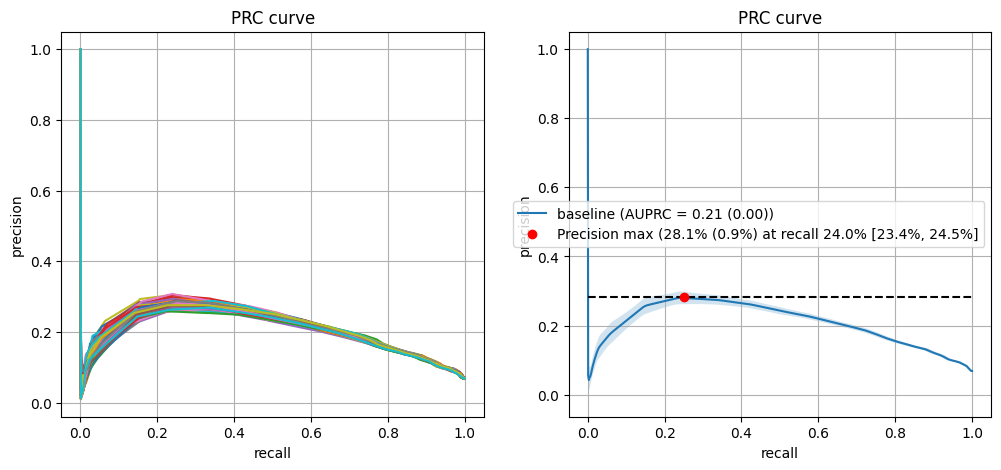

In [7]:
# PRC curves
plt.figure(figsize=(12, 5))

recall = np.linspace(0, 1, 1000)
# plot the ROC curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for i in range(len(precision_list)):
    plt.plot(recall, precision_list[i])
# plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('PRC curve')
plt.grid()

plt.subplot(1, 2, 2)

plt.fill_between(
    dict_results['fprs'],
    dict_results['precision'].mean(0) - 2 * dict_results['precision'].std(0),
    dict_results['precision'].mean(0) + 2 * dict_results['precision'].std(0),
    alpha=0.2,
)
plt.plot(
    dict_results['fprs'],
    dict_results['precision'].mean(0),
    label=f"baseline (AUPRC = {print_one_stat(pd.Series(dict_results['auprcs']),False)})",
)
plt.plot([0, 1], [dict_results['precision_threshold'].mean()]*2, 'k--')
plt.plot([dict_results['recall_threshold'].mean()], [dict_results['precision_threshold'].mean()], 'ro', label=f"Precision max ({print_one_stat(pd.Series(dict_results['precision_threshold']),True)} at recall {print_one_stat(pd.Series(dict_results['recall_threshold']), True)}")
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('PRC curve')
plt.legend()
plt.grid()
plt.show()

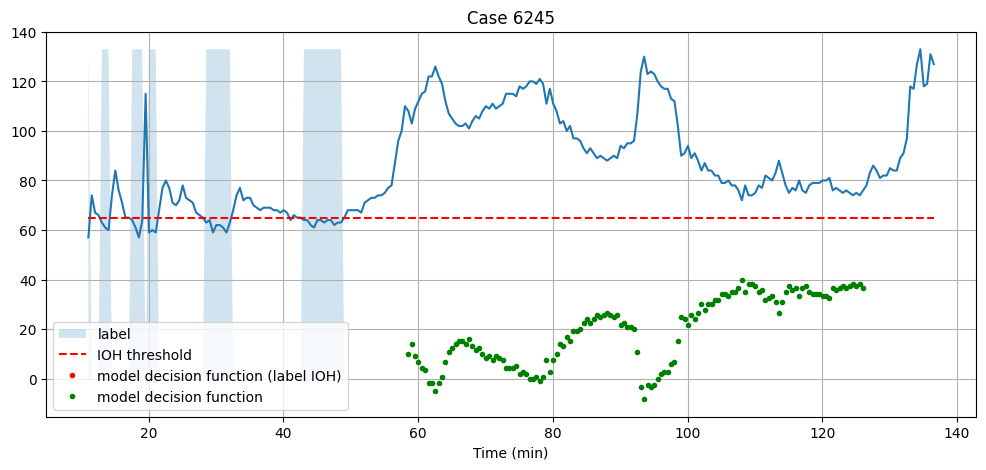

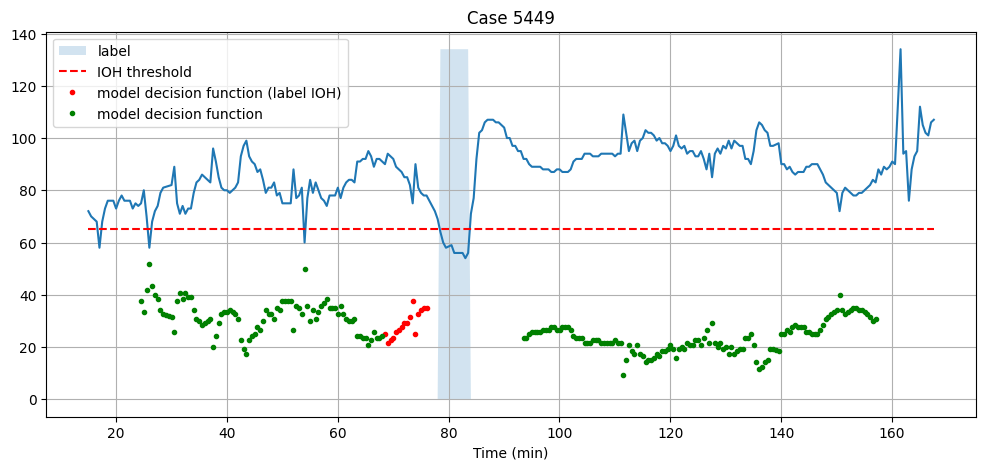

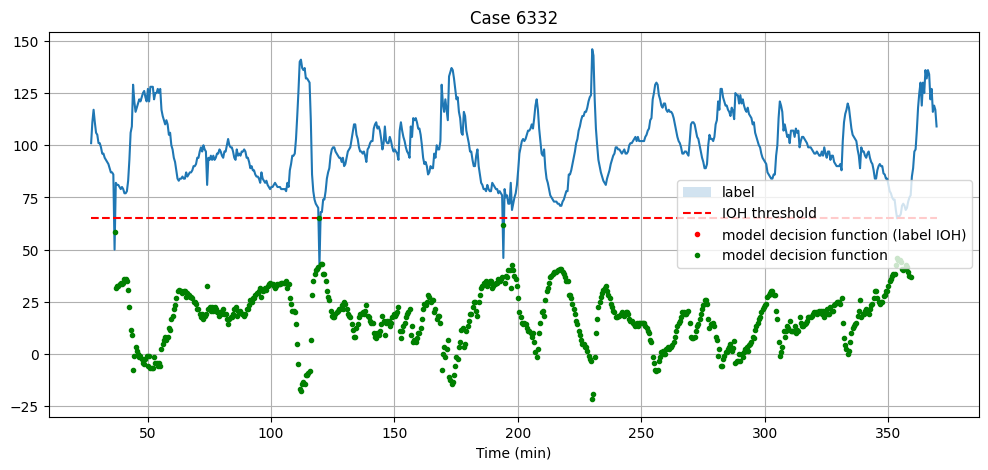

In [ ]:
# plot 3 random cases with the corresponding decision function
np.random.seed(12)
cases = np.random.choice(test['caseid'].unique(), 3, replace=False)

for case in cases:
    
    raw_case = load_labelized_cases(dataset_path=Path(f'data/datasets/{dataset_name}/'), caseid=case)

    segment_data = test[test['caseid'] == case]

    segment_data = segment_data.dropna(subset=[FEATURE_NAME])
    x_test = segment_data[FEATURE_NAME].values.reshape(-1, 1)
    y_test_case = segment_data['label'].values
    y_pred_case  = 1 - x_test/120

    plt.figure(figsize=(12, 5))
    plt.fill_between(raw_case.index.seconds/60, np.zeros(len(raw_case.index)), raw_case.label*raw_case['mbp'].max(), label='label', alpha=0.2)
    # FIX: NA values in mbp, missing fillna?
    plt.plot(raw_case.index.seconds/60, raw_case['mbp'])
    plt.hlines(65, raw_case.index.seconds[0]/60, raw_case.index.seconds[-1]/60, color='r', linestyle='--', label='IOH threshold')
    plt.plot(segment_data[segment_data.label>0].time / np.timedelta64(1, 's') /60,y_pred_case[segment_data.label>0]*100, 'r.', label='model decision function (label IOH)')
    plt.plot(segment_data[segment_data.label==0].time / np.timedelta64(1, 's') /60,y_pred_case[segment_data.label==0]*100, 'g.', label='model decision function')
    # plt.plot(segment_data['time']/60, segment_data[f'{FEATURE_NAME}_ema_{HALF_TIME_FILTERING}'], '*', label='label')
    plt.xlabel('Time (min)')
    # plt.xlim([97, 110])
    # plt.xlim([235, 245])
    # plt.ylim([42, 80])
    plt.legend()
    plt.title(f'Case {case}')
    plt.grid()
    plt.show()
